# Recurrent Neural Network (RNN)

Tutorial: https://www.tensorflow.org/text/tutorials/text_classification_rnn

https://developers.google.com/machine-learning/glossary/#recurrent_neural_network


A RNN is a neural network that is run multiple times, and parts of each run feeds into the next run. To be more specifc, hidden layers from the previous run will provide part of the input to that *same hidden layer* on the following run. This is good for evaluating sequences because the hiddne layers can learn from previous runs of the neural network. The result of this practice means that the RNN can predict the meaning of the entire **sequence of words** instead of just the meaning of individual words. So good to apply RNN for time series analysis and also text classification. 




In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, plot_precision_recall_curve, make_scorer, recall_score, brier_score_loss, precision_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# libraries for cleaning
import re
import nltk
nltk.download("stopwords") # helps us get rid of stop words
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# tensorflow stuff
import tensorflow as tf


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


I'm using data where stop words are removed but I did not do any stemming because I'm working with LSTM where the meaning of the word depends on the context of the previous text - stemming might affect that meaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/UBDC_2021/Final/text_preprocessed.csv")
df = df.loc[:,["text","label"]]
# df = pd.read_csv("/content/drive/MyDrive/UBDC_2021/Final/combined_df_label2.csv")
# df = df.loc[:,["text","label"]]
df.head()

Mounted at /content/drive


,text,label
0,coronavirus outbreak live updates odisha conf...,0
1,for today may here s how to follow the lat...,0
2,coronavirus outbreak round the clock updates ...,0
3,watch live gov phil murphy will speak at p...,0
4,to all my friends in the people s republic of ...,0


In [ ]:
X = df.text
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.25, random_state=0)


# create a tf.data.Dataset object for easier iteration 
# it will give outputs as a tuple of (text (ie X_train/test),label (ie y_train/test))
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [ ]:
# shuffle data for training and make bathes
buffer_size = 10000
batch_size = 64 # larger batch size increases probability of model seeing positive class

train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [ ]:
# test to see if shuffling worked
for text, label in train_dataset.take(1):
  print(text.numpy()[:5])
  print(label.numpy()[:5])

[b'the lancet retracts large study on hydroxychloroquine  via  nbcnews'
 b' officialozfm my lazy girl  charlie   '
 b'covid     the immune system can fight back    sciencedaily '
 b' joebiden  we ve tested more than every country combined      president donald trump at white house press briefing on april          '
 b' repvaldemings  freckldfacemami you re right  not only from a moral perspective but also medical  amp  public health perspective  we need testing to reopen safely  they are deliberately hoarding  amp  giving preferences in tests ppe to commercial labs  amp  big vendors   not to urban hospitals docs ']
[0 0 0 1 0]


# Word Embeddings

Link: https://www.tensorflow.org/text/guide/word_embeddings 

Word embeddings are used because it gives us an efficient *dense* representation where similar words have similar encodings. 

By definition, an embedding is a dense vector of floating point values (where vector length is a parameter that we can specify). The embedding values are trainable parameters - this means they are weights that are learned by the model during training. For large datasets the number of dimensions can be as high as 1024 (smaller datasets usually have around 8 dimensions). 

We include an embedding layer in the model. An embedding layer will turn positive integers into dense vectors of a specified size. You can think of it as a lookup table that maps from integer indices (that represent specific words) to dense vectors (another word for the embeddings). **Experiment with the dimensionality/width of the embedding.**

When the embedding layer is created, the weights are randomly initialized and then adjusted via backpropagation. Since we're dealing with text, the embedding layer will take a 2d tensor of (batch_size, sequence_length). 

If we give the embedding layer a batch of sequences as an input, then we get a 3d floating point tensor of the shape (batch_size, sequence_length, embedding_dimensionality). 

Example below: 

`result = embedding_layer(tf.constant([[0, 1, 2], [3, 4, 5]]))`

`result.shape`

output: `TensorShape([2, 3, 5])`

https://www.tensorflow.org/text/guide/word_embeddings

In [ ]:
# use .cache to keep data in memory after its loaded off disk 
# ensures that dataset does not become a bottleneck 
# .prefetch() overlaps datapreprocessing & model execution

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size = AUTOTUNE)
embedd_vocab_size = 30000 # size of vocabulary
# here i've embedded a 30000 word vocabulary into 8 dimensions
embedding_layer = tf.keras.layers.Embedding(embedd_vocab_size, 8) 

In [ ]:
# will need to include removing stop words & stemming here because I 
# am not using Countvectorizer() to remove the stopwords
def cleaning_words(phrase):
  tweet = tf.strings.lower(phrase) # make all letters lower case
  tweet = tf.strings.regex_replace(phrase,"http\S+", "") # remove all URLs
  tweet = tf.strings.regex_replace(tweet,'[^a-zA-z]',' ') # remove punctuation
  tweet = tf.strings.regex_replace(tweet,'@\S+|https?://\S+','') # remove @ sign
  return tweet

In [ ]:
# preprocess text by putting it through the textvectorization layer 
# note this is NOT embedding - this is simply the cleaning phase
vocab_size = 30000 
sequence_length = 300 
# the text vectorization layer is going to normalize, split, and matp string values 
# into integers - embedding will then map those integers into vectors 
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(standardize=cleaning_words,
                                                                       max_tokens = vocab_size, 
                                                                       output_sequence_length = sequence_length)
encoder.adapt(train_dataset.map(lambda text, label: text)) # set layer vocab

In [ ]:
# test the encoder
# the results are sorted by frequency
vocabularly_15 = np.array(encoder.get_vocabulary())
vocabularly_15[:15]

array(['', '[UNK]', 'the', 'to', 'and', 'of', 'a', 'for', 'in', 'covid',
       'is', 'you', 'i', 'it', 'that'], dtype='<U32')

# Model Sequence

1. Input layer
2. Text vectorization 
  - Here we turn invidiual words into integers
3. Embedding
  - Here we turn integers into vectors in n dimensions
4. Bi-directional training occurs
  - The `tf.keras.layers.Bidirectinal` wrapper can be used with an RNN lyer. It will propagate the input forwards **and** backwards and then concatenate the final output
  - The main advantage of bidirectional RNNS is that the signal from the beginning of the input does not beed to processed all the way through every timestep to affect the output
5. Dense Layer
  - For some final processing and to convert the output of the RNN into a single logit
6. Classification/output

In [ ]:
model = tf.keras.Sequential([
                             encoder, 
                             tf.keras.layers.Embedding(
                                 input_dim = len(encoder.get_vocabulary()), 
                                 output_dim = batch_size, 
                                 mask_zero = True, # handles variable sequence lengths 
                                 name = "embedding"
                             ), 
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(batch_size)), 
                             tf.keras.layers.Dense(batch_size, activation = "relu"),
                             tf.keras.layers.Dense(1)
])

In [ ]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir = "logs")

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer = tf.keras.optimizers.Adam(1e-4), 
              metrics = ["accuracy"])

In [ ]:
epochs = 3
history = model.fit(train_dataset, epochs = epochs, 
                    validation_data = val_dataset, 
                    validation_steps = 30, callbacks  = [tb_callback])

Epoch 1/3
1947/1947 [==============================] - 1166s 594ms/step - loss: 0.1280 - accuracy: 0.9691 - val_loss: 0.0770 - val_accuracy: 0.9781
Epoch 2/3
1947/1947 [==============================] - 1168s 600ms/step - loss: 0.0418 - accuracy: 0.9868 - val_loss: 0.0655 - val_accuracy: 0.9828
Epoch 3/3
1947/1947 [==============================] - 1165s 599ms/step - loss: 0.0275 - accuracy: 0.9915 - val_loss: 0.0676 - val_accuracy: 0.9839


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 64)           1920000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,994,369
Trainable params: 1,994,369
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(test_loss)
print(test_acc)

866/866 [==============================] - 121s 139ms/step - loss: 0.0521 - accuracy: 0.9866
0.05208027735352516
0.9865982532501221


In [ ]:
import tensorflow_datasets as tfds

In [ ]:
X_test_final = test_dataset.map(lambda text, label: text)
y_test_final = test_dataset.map(lambda text, label: label)

In [ ]:
from sklearn.metrics import classification_report
y_test_pred = model.predict(X_test_final, verbose = 1)

866/866 [==============================] - 120s 136ms/step


In [ ]:
len(y_test_pred)

55366

In [ ]:
# X_test_final = test_dataset.map(lambda text, label: text)
# y_test_final = test_dataset.map(lambda text, label: label)
# y_test_final = list(y_test_final.unbatch().take(-1).as_numpy_iterator())

In [ ]:
y_test_pred_boolean = tf.greater(y_test_pred, 0) # adjust this later
print(classification_report(y_test, y_test_pred_boolean))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     52750
           1       0.93      0.77      0.84      2616

    accuracy                           0.99     55366
   macro avg       0.96      0.88      0.92     55366
weighted avg       0.99      0.99      0.99     55366



In [ ]:
y_test_pred_boolean = tf.greater(tf.sigmoid(y_test_pred), 0.5) # adjust this later
print(classification_report(y_test, y_test_pred_boolean))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     52750
           1       0.93      0.77      0.84      2616

    accuracy                           0.99     55366
   macro avg       0.96      0.88      0.92     55366
weighted avg       0.99      0.99      0.99     55366



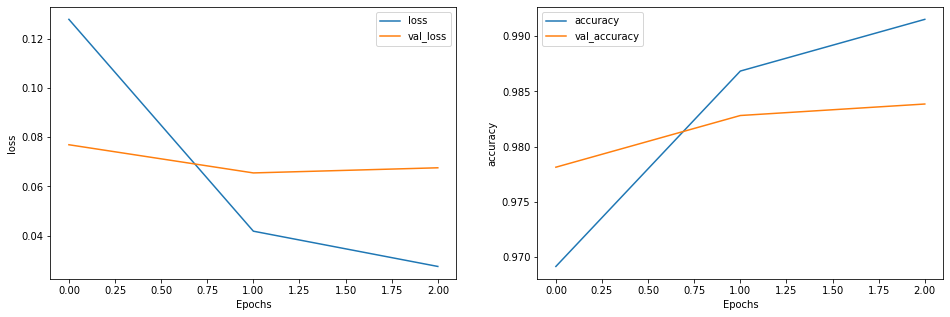

In [ ]:
plt.figure(figsize = (16,5))
plt.subplot(1,2,1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"],"")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(["loss", "val_loss"])
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"],"")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(["accuracy", "val_accuracy"])

In [ ]:
test_final = pd.read_csv("/content/drive/MyDrive/UBDC_2021/Final/english_test_with_labels.csv")
test_final = test_final.iloc[:,1:]
print(test_final.head())
label_change = lambda x: 1 if x == "fake" else 0
y = test_final.iloc[:,1]
test_final.iloc[:,1] = y.map(label_change)
print(test_final.head())

X_test_final = test_final.iloc[:,0]
y_test_final = test_final.iloc[:,1]

# create a tf.data.Dataset object for easier iteration 
# it will give outputs as a tuple of (text (ie X_train/test),label (ie y_train/test))
final_test_dataset = tf.data.Dataset.from_tensor_slices((X_test_final, y_test_final)).batch(batch_size)
X_test_final = final_test_dataset.map(lambda text, label: text)

y_test_pred = model.predict(X_test_final)
y_test_pred_boolean = tf.greater(y_test_pred, 0) # adjust this later
print(classification_report(y_test_final, y_test_pred_boolean))

                                               tweet label
0  Our daily update is published. States reported...  real
1             Alfalfa is the only cure for COVID-19.  fake
2  President Trump Asked What He Would Do If He W...  fake
3  States reported 630 deaths. We are still seein...  real
4  This is the sixth time a global health emergen...  real
                                               tweet  label
0  Our daily update is published. States reported...      0
1             Alfalfa is the only cure for COVID-19.      1
2  President Trump Asked What He Would Do If He W...      1
3  States reported 630 deaths. We are still seein...      0
4  This is the sixth time a global health emergen...      0
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1120
           1       0.99      0.06      0.12      1020

    accuracy                           0.55      2140
   macro avg       0.76      0.53      0.41      2140
weighted avg  

In [ ]:
random_text = ("Please get vaccinated - it'll stop the spread")
random_text = np.array([random_text])
print(model.predict(random_text))
print(tf.sigmoid(model.predict(random_text)))

random_text = ("fauci and bill gates want to ban hydroxychloroquine")
random_text = np.array([random_text])
print(model.predict(random_text))
print(tf.sigmoid(model.predict(random_text)))

random_text = ("We need lockdowns! COVID-19 isn't just the flu!")
random_text = np.array([random_text])
print(model.predict(random_text))
print(tf.sigmoid(model.predict(random_text)))

random_text = ("More lockdowns more problems - the elite are trying to trap us")
random_text = np.array([random_text])
print(model.predict(random_text))
print(tf.sigmoid(model.predict(random_text)))

[[-2.2110972]]
tf.Tensor([[0.09875834]], shape=(1, 1), dtype=float32)
[[2.2402117]]
tf.Tensor([[0.9038029]], shape=(1, 1), dtype=float32)
[[-5.1659474]]
tf.Tensor([[0.00567523]], shape=(1, 1), dtype=float32)
[[-4.35103]]
tf.Tensor([[0.01272938]], shape=(1, 1), dtype=float32)


# Imbalance

Will now deal with the imbalance

In [ ]:
real = y_train.loc[y_train==0].shape[0]
fake = y_train.loc[y_train==1].shape[0]
print(f"real is {real}")
print(f"fake is {fake}")
print(f"% fake is {fake/(fake+real)*100}")
initial_bias = np.log(fake/real)
print(f"the initial bias is {initial_bias}")

real is 118581
fake is 5990
% fake is 4.808502781546267
the initial bias is -2.985504859241621


In [ ]:
# pass keras weight for each class so that the model pays attention to examples 
# from an underpresented class
total = real + fake
weight_0 = (1/real)*(total/2.0)
weight_1 = (1/fake)*(total/2.0)
class_weight = {0:weight_0, 1:weight_1}
print(f"Weight 0 clas is {weight_0}")
print(f"Weight 1 class is {weight_1}")

Weight 0 clas is 0.5252569973267218
Weight 1 class is 10.398247078464108


In [ ]:
# the nice thing about using the Adam optimizer is that it is unaffected by 
# the change in scaling 
# additionally, keep in mind that total losses are not comparable between the model now 
# and the model we had earlier w/o the class weights

model_weight = tf.keras.Sequential([
                             encoder, 
                             tf.keras.layers.Embedding(
                                 input_dim = len(encoder.get_vocabulary()), 
                                 output_dim = batch_size, 
                                 mask_zero = True, # handles variable sequence lengths 
                                 name = "embedding"
                             ), 
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(batch_size)), 
                             tf.keras.layers.Dense(batch_size, activation = "relu"),
                             tf.keras.layers.Dense(1)
])
model_weight.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer = tf.keras.optimizers.Adam(1e-4), 
              metrics = ["accuracy"])
epochs = 3
history_weight = model_weight.fit(train_dataset, epochs = epochs, 
                    validation_data = val_dataset, 
                    validation_steps = 30, callbacks  = [tb_callback], 
                    class_weight=class_weight)


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/3
1947/1947 [==============================] - 1185s 604ms/step - loss: 0.3582 - accuracy: 0.9485 - val_loss: 0.2046 - val_accuracy: 0.9547
Epoch 2/3
1947/1947 [==============================] - 1164s 598ms/step - loss: 0.1486 - accuracy: 0.9679 - val_loss: 0.1446 - val_accuracy: 0.9583
Epoch 3/3
1947/1947 [==============================] - 1161s 596ms/step - loss: 0.0915 - accuracy: 0.9774 - val_loss: 0.1170 - val_accuracy: 0.9651


In [ ]:
test_loss, test_acc = model_weight.evaluate(test_dataset)
print(test_loss)
print(test_acc)

866/866 [==============================] - 117s 135ms/step - loss: 0.1067 - accuracy: 0.9700
0.10666097700595856
0.970017671585083


In [ ]:
X_test_final = test_dataset.map(lambda text, label: text)
y_test_final = test_dataset.map(lambda text, label: label)
y_test_pred = model_weight.predict(X_test_final, verbose = 1)
y_test_pred_boolean = tf.greater(y_test_pred, 0) # adjust this later
print(classification_report(y_test, y_test_pred_boolean))

866/866 [==============================] - 118s 133ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     52750
           1       0.56      0.86      0.68      2616

    accuracy                           0.96     55366
   macro avg       0.78      0.91      0.83     55366
weighted avg       0.97      0.96      0.97     55366



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.9717489238662551

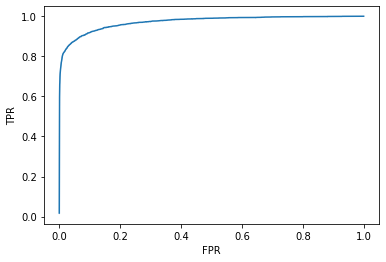

In [ ]:
fpr, tpr, _ = roc_curve(y_test, tf.sigmoid(y_test_pred))
ax = sns.lineplot(fpr, tpr)
ax.set(xlabel = "FPR", ylabel = "TPR")
auc(fpr, tpr)

In [ ]:
test_final = pd.read_csv("/content/drive/MyDrive/UBDC_2021/Final/english_test_with_labels.csv")
test_final = test_final.iloc[:,1:]
print(test_final.head())
label_change = lambda x: 1 if x == "fake" else 0
y = test_final.iloc[:,1]
test_final.iloc[:,1] = y.map(label_change)
print(test_final.head())

X_test_final = test_final.iloc[:,0]
y_test_final = test_final.iloc[:,1]

# create a tf.data.Dataset object for easier iteration 
# it will give outputs as a tuple of (text (ie X_train/test),label (ie y_train/test))
final_test_dataset = tf.data.Dataset.from_tensor_slices((X_test_final, y_test_final)).batch(batch_size)
X_test_final = final_test_dataset.map(lambda text, label: text)

y_test_pred = model_weight.predict(X_test_final)
y_test_pred_boolean = tf.greater(y_test_pred, 0) # adjust this later
print(classification_report(y_test_final, y_test_pred_boolean))

                                               tweet label
0  Our daily update is published. States reported...  real
1             Alfalfa is the only cure for COVID-19.  fake
2  President Trump Asked What He Would Do If He W...  fake
3  States reported 630 deaths. We are still seein...  real
4  This is the sixth time a global health emergen...  real
                                               tweet  label
0  Our daily update is published. States reported...      0
1             Alfalfa is the only cure for COVID-19.      1
2  President Trump Asked What He Would Do If He W...      1
3  States reported 630 deaths. We are still seein...      0
4  This is the sixth time a global health emergen...      0
              precision    recall  f1-score   support

           0       0.62      0.94      0.75      1120
           1       0.84      0.37      0.51      1020

    accuracy                           0.67      2140
   macro avg       0.73      0.65      0.63      2140
weighted avg  

In [ ]:
weights = model_weight.get_layer("embedding").get_weights()[0]
vocab = encoder.get_vocabulary()

In [ ]:
random_text = ("Please get vaccinated - it'll stop the spread")
random_text = np.array([random_text])
print(model_weight.predict(random_text))
print(tf.sigmoid(model_weight.predict(random_text)))

random_text = ("fauci and bill gates want to ban hydroxychloroquine")
random_text = np.array([random_text])
print(model_weight.predict(random_text))
print(tf.sigmoid(model_weight.predict(random_text)))

random_text = ("We need lockdowns! COVID-19 isn't just the flu!")
random_text = np.array([random_text])
print(model_weight.predict(random_text))
print(tf.sigmoid(model_weight.predict(random_text)))

random_text = ("More lockdowns more problems - the elite are trying to trap us")
random_text = np.array([random_text])
print(model_weight.predict(random_text))
print(tf.sigmoid(model_weight.predict(random_text)))

[[0.93334085]]
tf.Tensor([[0.7177526]], shape=(1, 1), dtype=float32)
[[4.9390373]]
tf.Tensor([[0.99288946]], shape=(1, 1), dtype=float32)
[[-1.1809398]]
tf.Tensor([[0.23488325]], shape=(1, 1), dtype=float32)
[[0.03023139]]
tf.Tensor([[0.5075573]], shape=(1, 1), dtype=float32)


In [ ]:
X = df.text
y = df.label
full_dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size).cache().prefetch(buffer_size = AUTOTUNE)
X = full_dataset.map(lambda text, label: text)
all_y = tf.sigmoid(model_weight.predict(X))
df["probabilities"] = all_y.numpy()
print(df.info())
df.to_csv("/content/drive/MyDrive/UBDC_2021/Final/rnn_probabilities.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221461 entries, 0 to 221460
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   text           221461 non-null  object 
 1   label          221461 non-null  int64  
 2   probabilities  221461 non-null  float32
dtypes: float32(1), int64(1), object(1)
memory usage: 4.2+ MB
None


In [ ]:
X = test_final.tweet
y = test_final.label
full_dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size).cache().prefetch(buffer_size = AUTOTUNE)
X = full_dataset.map(lambda text, label: text)
all_y = tf.sigmoid(model_weight.predict(X))
test_final["probabilities"] = all_y.numpy()
print(test_final.info())
test_final.to_csv("/content/drive/MyDrive/UBDC_2021/Final/dataset2_probabilities.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tweet          2140 non-null   object 
 1   label          2140 non-null   int64  
 2   probabilities  2140 non-null   float32
dtypes: float32(1), int64(1), object(1)
memory usage: 41.9+ KB
None


In [ ]:
# export the model 
# dataset_name = "covid"
# saved_model_path = '/content/drive/MyDrive/UBDC_2021/Final/{}_rnn'.format(dataset_name.replace('/', '_'))
# model.save(saved_model_path, include_optimizer=False)

In [ ]:
# to reload model
#reloaded_model = tf.saved_model.load(saved_model_path)

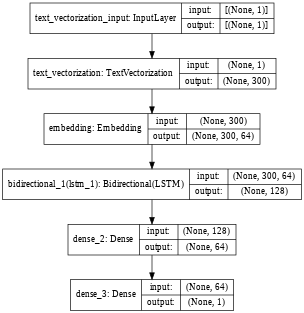

In [ ]:
tf.keras.utils.plot_model(model_weight, show_shapes=True, dpi=48)

In [ ]:
import io
out_vector = io.open("vectors.tsv","w",encoding = "utf-8")
out_meta = io.open("metadata.tsv", "w", encoding = "utf-8")

for i, word in enumerate(vocab):
  if i==0:
    continue # 0 is padding so we skip
  vec = weights[i]
  out_vector.write("\t".join([str(x) for x in vec]) + "\n")
  out_meta.write(word + "\n")
out_vector.close()
out_meta.close()

# download to colab
try: 
  from google.colab import files
  files.download("vectors.tsv")
  files.download("metadata.tsv")
except Exception: 
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
tf.keras.utils.plot_model(model_weight, show_shapes=True, dpi=100, to_file="/content/drive/MyDrive/UBDC_2021/Final/modelfig.pdf")